In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import torch
from time import time
from fvcore.nn import FlopCountAnalysis
from src.models.lbcnn.lbc_unet import SkinnySmallUNetLBP, SmallUNetLBP
from src.models.unet.unet_model import SkinnySmallUNet, SmallUNet
from src.models.dsc.dsc_lbc_unet import DSCSmallUNetLBP, SkinnyDSCSmallUNetLBP
from src.models.dsc.dsc_unet import SkinnySmallUNetDSC, SmallUNetDSC
import torch
from src.datasets.ice import IceForVisualizing
import numpy as np
import os
from torch import nn
from src.metrics.segmentation import _fast_hist, per_class_pixel_accuracy, jaccard_index
import torch.nn.functional as F
import matplotlib

In [2]:
latex = True
#plotting and colour set ups
if latex:
#     matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
#         'text.usetex': True,
        'pgf.rcfonts': False,
    })

In [3]:
def eval_model(model: nn.Module, checkpoint_path: str, title: str, img_number, mobile: bool = False) -> None:
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.train()
    out = nn.Softmax(dim=1)

    mask_list, pred_list = [], []

    img = val_set[img_number]['image'].to(device=device).unsqueeze(0)
    mask = val_set[img_number]['mask'].to(device=device, dtype=torch.long).unsqueeze(0)
    img_orig = val_set[img_number]['img_orig'].to(device=device)

    if mobile:
        imgs = torch.stack([img, img], dim=0).squeeze(1)
        with torch.no_grad():
            output = model(imgs)['out']
        sftmx = out(output)
        argmx = torch.argmax(sftmx, dim=1)[0].unsqueeze(0)
        hist = _fast_hist(mask.squeeze(0), argmx.to(dtype=torch.long), 3)
        iou = jaccard_index(hist)[0]
        acc = per_class_pixel_accuracy(hist)[0]
        loss = F.cross_entropy(output[0].unsqueeze(0), mask.squeeze(1)).detach().item()
    else:
        with torch.no_grad():
            output = model(img)
        sftmx = out(output)
        argmx = torch.argmax(sftmx, dim=1)
        hist = _fast_hist(mask.squeeze(0), argmx.to(dtype=torch.long), 3)
        iou = jaccard_index(hist)[0]
        acc = per_class_pixel_accuracy(hist)[0]
        loss = F.cross_entropy(output, mask.squeeze(1)).detach().item()
    print(model.__class__.__name__, iou)
    
    img_np = img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    img_orig_np = img_orig.permute(0, 2, 1).detach().cpu().numpy()
    mask_np = mask.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    argmx_np = argmx.permute(1, 2, 0).detach().cpu().numpy()
    return img_orig_np, mask_np, argmx_np

In [6]:
def plot_example(ax, img, is_img=False, x_label=None, y_label=None):
    ax.imshow(img, cmap='gray')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis=u'both', which=u'both',length=0)
#     ax.axis('off')
    if x_label:
        ax.set_xlabel(x_label)
    if y_label:
        ax.set_ylabel(y_label) # , rotation=0)
    
def plot_column(ind, img_number, epoch=10):
    x_label, y_label = None, None
    img, mask, pred = eval_model(
        SkinnySmallUNet(n_channels=3, n_classes=3, bilinear=True).to(device), 
        f'/home/dsola/repos/PGA-Net/checkpoints/noble_forest_358_skinny_small_unet/epoch{epoch}.pth', 
        'Full Unet, 80 epochs', img_number
    )
    if img_number==6:
        y_label = 'Image'
    plot_example(axs[0, ind], np.flipud(np.rot90(img)), x_label=x_label, y_label=y_label)
    if img_number==6:
        y_label = 'Ground Truth'
    plot_example(axs[1, ind], mask, x_label=x_label, y_label=y_label)
    if img_number==6:
        y_label = 'Skinny UNet'
    plot_example(axs[2, ind], pred, x_label=x_label, y_label=y_label)

    img, mask, pred = eval_model(
        SkinnySmallUNetDSC(n_channels=3, n_classes=3, bilinear=True).to(device), 
        f'/home/dsola/repos/PGA-Net/checkpoints/ancient_grass_357_skinny_small_dsc_unet/epoch{epoch}.pth', 
        'DSC UNet, 80 epochs', img_number
    )
    if img_number==6:
        y_label = 'Skinny DSC UNet'
    plot_example(axs[3, ind], pred, x_label=x_label, y_label=y_label)

    img, mask, pred = eval_model(
        SkinnySmallUNetLBP(3, 3).to(device), 
        f'/home/dsola/repos/PGA-Net/checkpoints/trim_field_359_skinny_small_lbc_unet/epoch{epoch}.pth', 
        'LBC Unet, 80 epochs', img_number
    )
    if img_number==6:
        y_label = 'Skinny LBC UNet'
    plot_example(axs[4, ind], pred, x_label=x_label, y_label=y_label)

    img, mask, pred = eval_model(
        SkinnyDSCSmallUNetLBP(3, 3).to(device), 
        f'/home/dsola/repos/PGA-Net/checkpoints/clear_lake_355_skinny_small_dsc_lbc_unet/epoch{epoch}.pth', 
        'DSC LBC UNet, 80 epochs', img_number
    )
    if img_number==6:
        y_label = 'Skinny DSC LBC UNet'
    plot_example(axs[5, ind], pred, x_label=x_label, y_label=y_label)

    img, mask, pred = eval_model(
        SmallUNet(n_channels=3, n_classes=3, bilinear=True).to(device), 
        f'/home/dsola/repos/PGA-Net/checkpoints/laced_disco_238_small_unet_ice/epoch{epoch}.pth', 
        'Full Unet, 80 epochs', img_number
    )
    if img_number==6:
        y_label = 'Small UNet'
    plot_example(axs[6, ind], pred, x_label=x_label, y_label=y_label)

    img, mask, pred = eval_model(
         SmallUNetDSC(n_channels=3, n_classes=3, bilinear=True).to(device), 
        f'/home/dsola/repos/PGA-Net/checkpoints/cosmic_waterfall_315_small_dsc_unet_ice/epoch{epoch}.pth', 
        'Full Unet, 80 epochs', img_number
    )
    if img_number==6:
        y_label = 'Small DSC UNet'
    plot_example(axs[7, ind], pred, x_label=x_label, y_label=y_label)

    img, mask, pred = eval_model(
        SmallUNetLBP(3, 3).to(device), 
        f'/home/dsola/repos/PGA-Net/checkpoints/sandy_moon_228_small_lbc_unet_ice/epoch{epoch}.pth', 
        'Full Unet, 80 epochs', img_number
    )
    if img_number==6:
        y_label = 'Small LBC UNet'
    plot_example(axs[8, ind], pred, x_label=x_label, y_label=y_label)

    img, mask, pred = eval_model(
        DSCSmallUNetLBP(3, 3).to(device), 
        f'/home/dsola/repos/PGA-Net/checkpoints/still_paper_311_small_lbc_dsc_unet_ice/epoch{epoch}.pth', 
        'DSC LBC Small UNet, 80 epochs', img_number
    )
    if img_number==6:
        y_label = 'Small DSC LBC UNet'
    plot_example(axs[9, ind], pred, x_label=x_label, y_label=y_label)


#     img, mask, pred = eval_model(
#         deeplabv3_mobilenet_v3_large(num_classes=3).to(device), 
#         f'/home/dsola/repos/PGA-Net/checkpoints/vivid_donkey_305_deeplab_mobilenet_ice/epoch{epoch}.pth', 
#         'DeepLab MobileNet, 80 epochs', img_number,
#         mobile=True
#     )
#     if img_number==6:
#         y_label = 'MobileNetV3 (DeepLabV3)'
#     plot_example(axs[10, ind], pred, x_label=x_label, y_label=y_label)

#     img, mask, pred = eval_model(
#         lraspp_mobilenet_v3_large(num_classes=3).to(device), 
#         f'/home/dsola/repos/PGA-Net/checkpoints/clean_darkness_312_laraspp_mobilenet_ice/epoch{epoch}.pth', 
#         'LRASPP MobileNet, 80 epochs', img_number,
#         mobile=True
#     )
#     if img_number==6:
#         y_label = 'MobileNetV3 (LR-ASPP)'
#     plot_example(axs[11, ind], pred, x_label=x_label, y_label=y_label)

SkinnySmallUNet tensor(0.4940, device='cuda:0')
SkinnySmallUNetDSC tensor(0.4807, device='cuda:0')
SkinnySmallUNetLBP tensor(0.5786, device='cuda:0')
SkinnyDSCSmallUNetLBP tensor(0.6184, device='cuda:0')
SmallUNet tensor(0.5417, device='cuda:0')
SmallUNetDSC tensor(0.5380, device='cuda:0')
SmallUNetLBP tensor(0.5171, device='cuda:0')
DSCSmallUNetLBP tensor(0.6296, device='cuda:0')
SkinnySmallUNet tensor(0.5031, device='cuda:0')
SkinnySmallUNetDSC tensor(0.4188, device='cuda:0')
SkinnySmallUNetLBP tensor(0.7371, device='cuda:0')
SkinnyDSCSmallUNetLBP tensor(0.7681, device='cuda:0')
SmallUNet tensor(0.4999, device='cuda:0')
SmallUNetDSC tensor(0.5272, device='cuda:0')
SmallUNetLBP tensor(0.6031, device='cuda:0')
DSCSmallUNetLBP tensor(0.6581, device='cuda:0')
SkinnySmallUNet tensor(0.5685, device='cuda:0')
SkinnySmallUNetDSC tensor(0.5239, device='cuda:0')
SkinnySmallUNetLBP tensor(0.5633, device='cuda:0')
SkinnyDSCSmallUNetLBP tensor(0.6222, device='cuda:0')
SmallUNet tensor(0.6590, dev

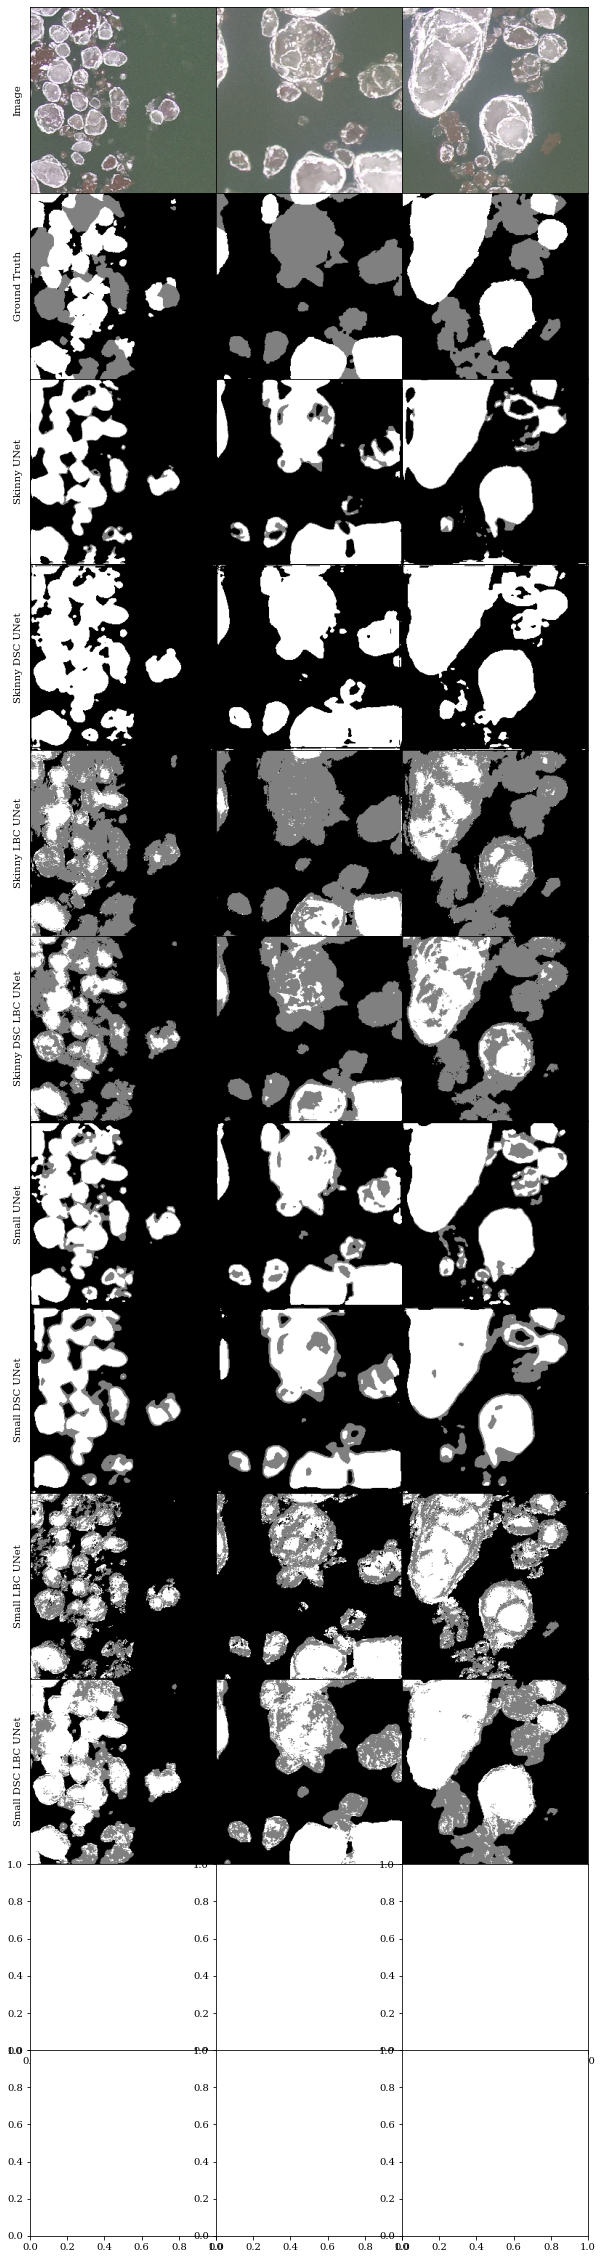

In [7]:
fig, axs = plt.subplots(12,3, figsize=(10, 41))

IMG_NUMBER = 6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = '/home/dsola/repos/PGA-Net/data/'
batch_size = 1
img_crop = 256
img_scale = 0.35

val_set = IceForVisualizing(os.path.join(data_dir, 'imgs'), os.path.join(data_dir, 'masks'),
              os.path.join(data_dir, 'txt_files'), 'val', img_scale, img_crop)

plot_column(0, 6, epoch=1)
plot_column(1, 7, epoch=1)
plot_column(2, 8, epoch=1)
fig.subplots_adjust(wspace=0, hspace=0)

In [8]:
# fig.savefig("../images/pred_results_skinny_one_epoch.svg", format='svg', dpi=1200)

In [10]:
d=DSCSmallUNetLBP(3, 3)